In [1]:
# Install google earth engine python API
# https://developers.google.com/earth-engine/python_install_manual
%pip install earthengine-api --upgrade pandas geopandas > /dev/null

Note: you may need to restart the kernel to use updated packages.


The system cannot find the path specified.


In [2]:
# Get a bounds of the Sviatohirsk city from OpenStreetMap API
# https://wiki.openstreetmap.org/wiki/Overpass_API

import requests


city_name = 'Кривий Ріг'
city_name_en = "Kryvyi Rih, Ukraine"
orbitProperties_pass='DESCENDING'
relativeOrbitNumber_start=65
url = f'https://overpass-api.de/api/interpreter?data=[out:json]; area[name="{city_name}"] -> .a; ( relation(area.a)[admin_level]; ); out geom;'
print(url)

response = requests.get(url)
data = response.json()
bounds = data['elements'][0]['bounds']

# Make a geojson file with bounds as a polygon
geoJSON = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry":
            {
                "type": "Polygon",
                "coordinates": [
                    [
                        [bounds['minlon'], bounds['minlat']],
                        [bounds['minlon'], bounds['maxlat']],
                        [bounds['maxlon'], bounds['maxlat']],
                        [bounds['maxlon'], bounds['minlat']],
                        [bounds['minlon'], bounds['minlat']]
                    ]
                ]
            }
        }
    ]
}
center=[(bounds['minlat'] + bounds['maxlat']) / 2, (bounds['minlon'] + bounds['maxlon']) / 2]
bounds

https://overpass-api.de/api/interpreter?data=[out:json]; area[name="Кривий Ріг"] -> .a; ( relation(area.a)[admin_level]; ); out geom;


{'minlat': 47.4566155,
 'minlon': 32.9595518,
 'maxlat': 48.3185181,
 'maxlon': 34.2378723}

In [3]:
# Plot the bounds on the map with folium
# https://python-visualization.github.io/folium/
import folium
import json

buffer_offset_x = -0.01
buffer_offset_y = -0.01
geoJSON_buffered = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry":
            {
                "type": "Polygon",
                "coordinates": [
                    [
                        [bounds['minlon'] - buffer_offset_x, bounds['minlat'] - buffer_offset_y],
                        [bounds['minlon'] - buffer_offset_x, bounds['maxlat'] + buffer_offset_y],
                        [bounds['maxlon'] + buffer_offset_x, bounds['maxlat'] + buffer_offset_y],
                        [bounds['maxlon'] + buffer_offset_x, bounds['minlat'] - buffer_offset_y],
                        [bounds['minlon'] - buffer_offset_x, bounds['minlat'] - buffer_offset_y]
                    ]
                ]
            }
        }
    ]
}

mp = folium.Map(location=center, zoom_start=11)
folium.GeoJson(json.dumps(geoJSON)).add_to(mp)
folium.GeoJson(json.dumps(geoJSON_buffered)).add_to(mp)
mp

In [4]:
import ee
import pandas as pd
import geopandas as gpd
ee.Authenticate(
    # force=True
)
ee.Initialize()

In [5]:
%pip install scipy folium

Note: you may need to restart the kernel to use updated packages.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
import folium
%matplotlib inline


In [7]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [8]:
aoi = ee.Geometry.Polygon(geoJSON['features'][0]['geometry']['coordinates'])
aoi_sub = ee.Geometry.Polygon(geoJSON_buffered['features'][0]['geometry']['coordinates'])

In [9]:
# Define the time range
start_date = '2022-02-16'
# end_date = '2022-02-24'
end_date = '2024-02-11'

# to define orbitProperties_pass and relativeOrbitNumber_start for your case use this link https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2

# Create an ImageCollection for the given time range and AOI
ffa_collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
              .filterBounds(aoi)
              .filterDate(ee.Date(start_date), ee.Date(end_date))
              .filter(ee.Filter.eq('orbitProperties_pass', orbitProperties_pass))
              .filter(ee.Filter.eq('relativeOrbitNumber_start', relativeOrbitNumber_start))
              .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
              .sort('system:time_start'))

ffa_fl_collection = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
              .filterBounds(aoi)
              .filterDate(ee.Date(start_date), ee.Date(end_date))
              .filter(ee.Filter.eq('orbitProperties_pass', orbitProperties_pass))
              .filter(ee.Filter.eq('relativeOrbitNumber_start', relativeOrbitNumber_start))
              .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
              .sort('system:time_start'))

ffa_db = ee.Image(ffa_collection.filterDate(ee.Date(start_date), ee.Date(end_date)).mosaic().clip(aoi))

(ffa_fl_collection.aggregate_array('date')
                 .map(lambda d: ee.String('T').cat(ee.String(d)))
                 .getInfo())


['T20220218',
 'T20220218',
 'T20220314',
 'T20220314',
 'T20220326',
 'T20220326',
 'T20220407',
 'T20220407',
 'T20220419',
 'T20220419',
 'T20220501',
 'T20220501',
 'T20220513',
 'T20220513',
 'T20220525',
 'T20220525',
 'T20220606',
 'T20220606',
 'T20220618',
 'T20220618',
 'T20220630',
 'T20220630',
 'T20220712',
 'T20220712',
 'T20220724',
 'T20220724',
 'T20220805',
 'T20220805',
 'T20220817',
 'T20220817',
 'T20220829',
 'T20220829',
 'T20220910',
 'T20220910',
 'T20220922',
 'T20220922',
 'T20221004',
 'T20221004',
 'T20221016',
 'T20221016',
 'T20221028',
 'T20221028',
 'T20221109',
 'T20221109',
 'T20221121',
 'T20221121',
 'T20221203',
 'T20221203',
 'T20221215',
 'T20221215',
 'T20221227',
 'T20221227',
 'T20230108',
 'T20230108',
 'T20230120',
 'T20230120',
 'T20230201',
 'T20230201',
 'T20230213',
 'T20230213',
 'T20230225',
 'T20230225',
 'T20230309',
 'T20230309',
 'T20230321',
 'T20230321',
 'T20230402',
 'T20230402',
 'T20230414',
 'T20230414',
 'T20230426',
 'T202

In [10]:
location = aoi.centroid().coordinates().getInfo()[::-1]

# Make an RGB color composite image (VV,VH,VV/VH).
rgb = ee.Image.rgb(ffa_db.select('VV'),
                   ffa_db.select('VH'),
                   ffa_db.select('VV').divide(ffa_db.select('VH')))

# Create the map object.
mp = folium.Map(location=location, zoom_start=11)

# Add the S1 rgb composite to the map object.
mp.add_ee_layer(rgb, {'min': [-20, -20, 0], 'max': [0, 0, 2]}, 'FFA')
folium.GeoJson(json.dumps(geoJSON)).add_to(mp)
# Add a layer control panel to the map.
mp.add_child(folium.LayerControl())

# Display the map.
display(mp)

In [11]:
import time
# Show relativeOrbitNumber_start for the first image in the collection
print(ffa_fl_collection.first().get('relativeOrbitNumber_start').getInfo())
# Show orbitProperties_pass for the first image in the collection
print(ffa_fl_collection.first().get('orbitProperties_pass').getInfo())
# Getting all the dates in the collection
acq_times = ffa_fl_collection.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]

65
DESCENDING


['02/18/22',
 '02/18/22',
 '03/14/22',
 '03/14/22',
 '03/26/22',
 '03/26/22',
 '04/07/22',
 '04/07/22',
 '04/19/22',
 '04/19/22',
 '05/01/22',
 '05/01/22',
 '05/13/22',
 '05/13/22',
 '05/25/22',
 '05/25/22',
 '06/06/22',
 '06/06/22',
 '06/18/22',
 '06/18/22',
 '06/30/22',
 '06/30/22',
 '07/12/22',
 '07/12/22',
 '07/24/22',
 '07/24/22',
 '08/05/22',
 '08/05/22',
 '08/17/22',
 '08/17/22',
 '08/29/22',
 '08/29/22',
 '09/10/22',
 '09/10/22',
 '09/22/22',
 '09/22/22',
 '10/04/22',
 '10/04/22',
 '10/16/22',
 '10/16/22',
 '10/28/22',
 '10/28/22',
 '11/09/22',
 '11/09/22',
 '11/21/22',
 '11/21/22',
 '12/03/22',
 '12/03/22',
 '12/15/22',
 '12/15/22',
 '12/27/22',
 '12/27/22',
 '01/08/23',
 '01/08/23',
 '01/20/23',
 '01/20/23',
 '02/01/23',
 '02/01/23',
 '02/13/23',
 '02/13/23',
 '02/25/23',
 '02/25/23',
 '03/09/23',
 '03/09/23',
 '03/21/23',
 '03/21/23',
 '04/02/23',
 '04/02/23',
 '04/14/23',
 '04/14/23',
 '04/26/23',
 '04/26/23',
 '05/08/23',
 '05/08/23',
 '05/20/23',
 '05/20/23',
 '06/01/23',

In [13]:
# im1 = ee.Image(ffa_fl_collection.filterDate(ee.Date('2022-02-16'), ee.Date('2022-02-17')).mosaic().clip(aoi))
# im2 = ee.Image(ffa_fl_collection.filterDate(ee.Date('2022-09-20'), ee.Date('2022-09-21')).mosaic().clip(aoi))
# ratio = im1.divide(im2)
# # print(ratio.getInfo())
# hist = ratio.reduceRegion(
#   ee.Reducer.fixedHistogram(0, 5, 500), aoi_sub,
#     scale=1,  # specify an appropriate scale for your data
#     maxPixels=1e9,
#     bestEffort=True
#   ).get('VV').getInfo()
# mean = ratio.reduceRegion(ee.Reducer.mean(), aoi_sub).get('VV').getInfo()
# variance = ratio.reduceRegion(ee.Reducer.variance(), aoi_sub).get('VV').getInfo()
# print('Mean: ', mean)
# print('Variance: ', variance)
# print('Hist: ', hist)
# a = np.array(hist)
# x = a[:, 0]
# y = a[:, 1] / np.sum(a[:, 1])
# plt.grid()
# plt.plot(x, y, '.')
# plt.show()


In [14]:
# im1.bandNames().getInfo()

In [15]:
# m = 5
# plt.grid()
# plt.plot(x, y, '.', label='data')
# plt.plot(x, f.pdf(x, 2*m, 2*m) / 100, '-r', label='F-dist')
# plt.legend()
# plt.show()

In [16]:
# print(mean, m/(m-1))
# print(variance, m*(2*m-1)/(m-1)**2/(m-2))

In [21]:
im1 = ee.Image(ffa_fl_collection.filterDate(ee.Date('2022-02-17'), ee.Date('2022-02-19')).mosaic().select('VV').clip(aoi))
im2 = ee.Image(ffa_fl_collection.filterDate(ee.Date('2022-02-07'), ee.Date('2022-02-09')).mosaic().select('VV').clip(aoi))
ratio = im1.divide(im2)

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=11)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 
                 'palette': ['black', 'white']
                 }, 'Ratio')
mp.add_child(folium.LayerControl())

display(mp)

EEException: Image.select: Pattern 'VH' did not match any bands.

In [ ]:
# Decision threshold alpha/2:
dt = f.ppf(0.0005, 2*m, 2*m)

# LRT statistics.
q1 = im1.divide(im2)
q2 = im2.divide(im1)


# Change map with 0 = no change, 1 = decrease, 2 = increase in intensity.
c_map = im1.multiply(0).where(q2.lt(dt), 1)
c_map = c_map.where(q1.lt(dt), 2)

# Mask no-change pixels.
c_map = c_map.updateMask(c_map.gt(0))

# Display map with red for increase and blue for decrease in intensity.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(
    location=location, tiles='cartodb positron',
    zoom_start=11)
folium.TileLayer('OpenStreetMap').add_to(mp)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 
                 'palette': ['black', 'white']
                 }, 'Ratio')
mp.add_ee_layer(c_map,
                {'min': 0, 'max': 2, 
                 'palette': ['black', 'blue', 'red']
                 },
                'Change Map')
mp.add_child(folium.LayerControl())

display(mp)

In [ ]:
def det(im):
  return im.expression('b(0) * b(1)')

# Number of looks.
m = 5

im1 = ee.Image(ffa_fl_collection.filterDate(ee.Date('2022-02-16'), ee.Date('2022-02-17')).mosaic().select('VV', 'VH').clip(aoi))
im2 = ee.Image(ffa_fl_collection.filterDate(ee.Date('2022-09-20'), ee.Date('2022-09-21')).mosaic().select('VV', 'VH').clip(aoi))

m2logQ = det(im1).log().add(det(im2).log()).subtract(
    det(im1.add(im2)).log().multiply(2)).add(4*np.log(2)).multiply(-2*m)

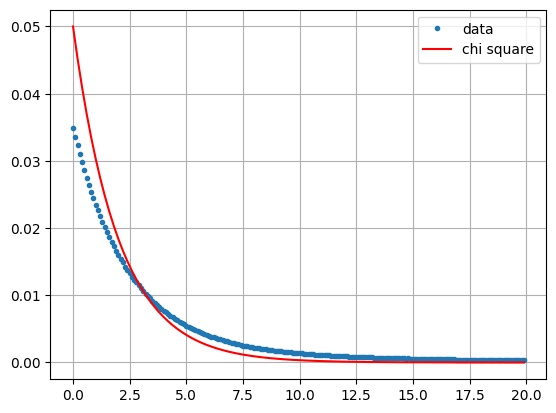

In [ ]:
hist = m2logQ.reduceRegion(
    ee.Reducer.fixedHistogram(0, 20, 200), aoi,
    scale=1,  # specify an appropriate scale for your data
    maxPixels=1e9,
    bestEffort=True
).get('VV').getInfo()
a = np.array(hist)
x = a[:, 0]
y = a[:, 1] / np.sum(a[:, 1])
plt.plot(x, y, '.', label='data')
plt.plot(x, chi2.pdf(x, 2)/10, '-r', label='chi square')
plt.legend()
plt.grid()
plt.show()

In [ ]:
im1 = ee.Image(ffa_fl_collection.filterDate(ee.Date('2022-02-16'), ee.Date('2022-02-17')).mosaic().clip(aoi))
im2 = ee.Image(ffa_fl_collection.filterDate(ee.Date('2022-09-20'), ee.Date('2022-09-21')).mosaic().clip(aoi))
def chi2cdf(chi2, df):
  ''' Chi square cumulative distribution function for df degrees of freedom
      using the built-in incomplete gamma function gammainc() '''
  return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

# The observed test statistic image -2logq.
m2logq = det(im1).log().add(det(im2).log()).subtract(
    det(im1.add(im2)).log().multiply(2)).add(4*np.log(2)).multiply(-2*m)

# The P value image prob(m2logQ > m2logq) = 1 - prob(m2logQ < m2logq).
p_value = ee.Image.constant(1).subtract(chi2cdf(m2logq, 2))

# Project onto map.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(p_value,
                {'min': 0,'max': 1, 'palette': ['black', 'white']}, 'P-value')
mp.add_child(folium.LayerControl())